In [1]:
%pip install -r requirements.txt -q


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import openeo
import xarray
import matplotlib.pyplot as plt

In [3]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [4]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [5]:


# Załaduj zbiór danych Sentinel-2
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": 3.20,
        "south": 51.18,
        "east": 3.25,
        "north": 51.21,
        "crs": "EPSG:4326",
    },
    bands=["SCL", "B08", "B11"],  # Dodaj B08 i B11
    max_cloud_cover=50,
)

In [6]:
s2_cube.download("load-raw.nc")

In [7]:
scl_band = s2_cube.band("SCL")
cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)

# TODO: TEMP WORKAROUND FOR OFFSET ERROR ON SCL BAND
cloud_mask = (scl_band == 3 - 1000) | (scl_band == 8 - 1000) | (scl_band == 9 - 1000)

In [8]:
cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)

In [9]:
cube_masked = s2_cube.mask(cloud_mask)

composite_masked = cube_masked.max_time()

In [10]:
composite_masked.download("load-composite-masked.nc")

In [11]:
ds = xarray.load_dataset("load-composite-masked.nc")


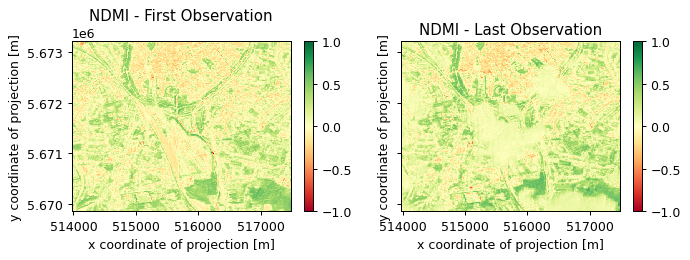

In [18]:
import matplotlib.pyplot as plt
import xarray as xr

# Wczytaj zbiór danych z pliku netCDF
ds = xr.load_dataset("load-raw.nc")

# Oblicz NDMI i dodaj do zbioru danych
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj xarray DataSet na DataArray z NDMI
data = ds[["NDMI"]].to_array(dim="bands")

# Sprawdź, czy w danych są dostępne różne czasy (t)
if 't' in data.dims:
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)

    # Ustaw zakres wartości vmin i vmax na -1 i 1
    im1 = data[{"bands": 0, "t": 0}].plot.imshow(vmin=-1, vmax=1, ax=axes[0], cmap='RdYlGn')
    im2 = data[{"bands": 0, "t": -1}].plot.imshow(vmin=-1, vmax=1, ax=axes[1], cmap='RdYlGn')

    # Ustawienia tytułów
    axes[0].set_title('NDMI - First Observation')
    axes[1].set_title('NDMI - Last Observation')


    plt.tight_layout()
    plt.show()
else:
    print("Brak danych czasowych (t) w zbiorze.")
